In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve, validation_curve

In [3]:
df = pd.read_csv("/Users/daviderickson/projects/us-education-datasets-unification-project/data/us-education-datasets-unification-project/states_all-cleaned.csv")

In [4]:
print('Rows, columns: ', df.shape)
print('Years/state', len(df)/50)
print('YEARs', df['YEAR'].min(), '--' , df['YEAR'].max())
print('\nSTATEs\n', df['STATE'].unique(), '\n')
print('Features:\n', df.columns.tolist(), '\n')

Rows, columns:  (1487, 25)
Years/state 29.74
YEARs 1992 -- 2017

STATEs
 ['ALABAMA' 'ALASKA' 'ARIZONA' 'ARKANSAS' 'CALIFORNIA' 'COLORADO'
 'CONNECTICUT' 'DELAWARE' 'DISTRICT_OF_COLUMBIA' 'FLORIDA' 'GEORGIA'
 'HAWAII' 'IDAHO' 'ILLINOIS' 'INDIANA' 'IOWA' 'KANSAS' 'KENTUCKY'
 'LOUISIANA' 'MAINE' 'MARYLAND' 'MASSACHUSETTS' 'MICHIGAN' 'MINNESOTA'
 'MISSISSIPPI' 'MISSOURI' 'MONTANA' 'NEBRASKA' 'NEVADA' 'NEW_HAMPSHIRE'
 'NEW_JERSEY' 'NEW_MEXICO' 'NEW_YORK' 'NORTH_CAROLINA' 'NORTH_DAKOTA'
 'OHIO' 'OKLAHOMA' 'OREGON' 'PENNSYLVANIA' 'RHODE_ISLAND' 'SOUTH_CAROLINA'
 'SOUTH_DAKOTA' 'TENNESSEE' 'TEXAS' 'UTAH' 'VERMONT' 'VIRGINIA'
 'WASHINGTON' 'WEST_VIRGINIA' 'WISCONSIN' 'WYOMING' 'AMERICAN_SAMOA'
 'BUREAU_OF_INDIAN_AFFAIRS' 'DOD_DOMESTIC' 'DOD_OVERSEAS' 'GUAM'
 'NORTHERN_MARIANAS' 'PUERTO_RICO' 'VIRGIN_ISLANDS' 'BI' 'DD'
 'NORTHERN_MARIANA_ISLANDS' 'DEPARTMENT_OF_DEFENSE'
 'BUREAU_OF_INDIAN_EDUCATION' 'DEPARTMENT_OF_DEFENSE_EDUCATION_ACTIVITY'
 'U.S._VIRGIN_ISLANDS' 'DOD_(OVERSEAS_AND_DOMESTIC_COM

Number of features:  23
Test scores are correlated with time.
Revenues and expenditures are highly correlated with each other.
School populations are highly correlated with each other.
School pops and Revs/Expenditures are highly intercorrelated.
Test scores are highly correlated with each other. AVG_8_READING_SCORE less so than the others.


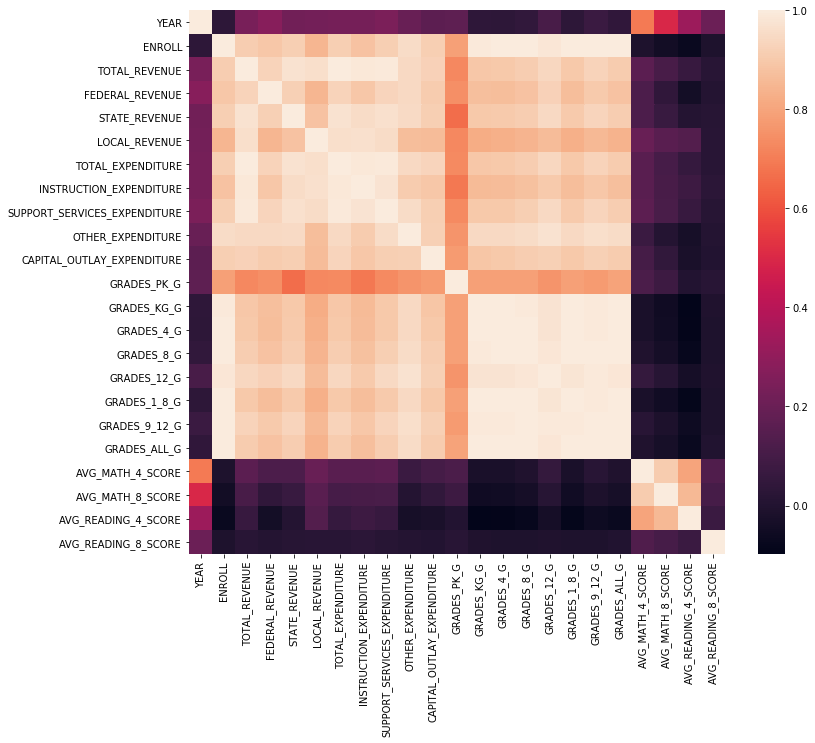

In [5]:
#plt.figure(figsize=(15,15))
corr = df.corr()
print('Number of features: ', len(corr))
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr)
print('Test scores are correlated with time.')
print('Revenues and expenditures are highly correlated with each other.')
print('School populations are highly correlated with each other.')
print('School pops and Revs/Expenditures are highly intercorrelated.')
print('Test scores are highly correlated with each other. AVG_8_READING_SCORE less so than the others.')

# PCA 

In [6]:
# PCA

from sklearn.decomposition import PCA
pca = PCA()
print(pca)

print(df.shape)

df1 = pd.get_dummies(df1, columns=['STATE'])
drop_cols = ['PRIMARY_KEY', 'YEAR', 'ENROLL', \
             'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', \
             'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', \
             'CAPITAL_OUTLAY_EXPENDITURE', \
             'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', \
             'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G']
df1 = df1.drop(drop_cols, axis=1)
df1 = df1.drop('AVG_MATH_4_SCORE', axis=1)
df1 = df.dropna(axis=0)
print(df1.shape)

# Scale features first
X = df1.loc[:,:].values
X_cols = df1.loc[:,:].columns
scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)

pca.fit(X_transformed)
X_pca = pca.fit(df1).transform(X_transformed)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
(1487, 25)
(412, 25)


3 PCA components explain the variance


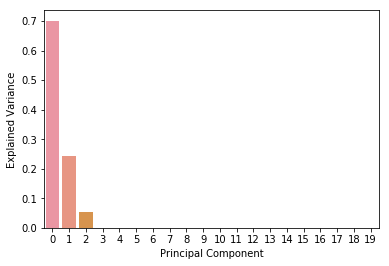

In [7]:
ax = sns.barplot(x=np.arange(20), y=pca.explained_variance_[0:20]/sum(pca.explained_variance_))
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
print('3 PCA components explain the variance')

(412, 54)
(1487, 25)


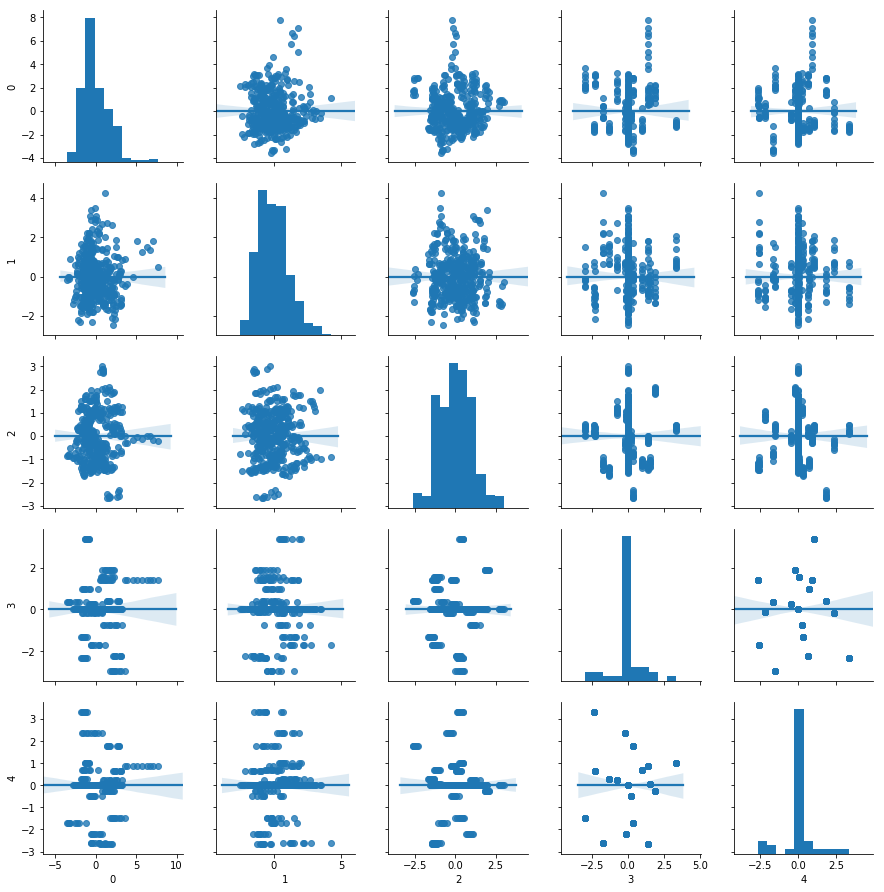

In [8]:
X_pca = pca.fit(X_transformed).transform(X_transformed)
X_pca_df = pd.DataFrame(X_pca)
print(X_pca_df.shape)
print(df.shape)
sns.pairplot(X_pca_df.iloc[:,0:5], kind='reg')

(54, 54)
Trivial: PCA Features not correlated


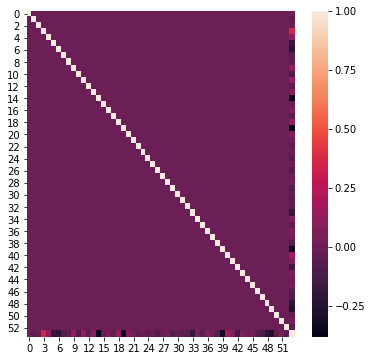

In [9]:
df_pca = pd.DataFrame(X_pca)
corr_pca = df_pca.corr()
print(corr_pca.shape)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corr_pca)
print('Trivial: PCA Features not correlated')

# Build Features: 

In [10]:
# Make a copy of the original data before modifying
# Use it for comparison later
df_orig = df.copy()

In [11]:
#Normalized features

df['avg_total_revenue']=df['TOTAL_REVENUE']/df['GRADES_ALL_G']
df['avg_total_expenditure'] = df['TOTAL_EXPENDITURE'] / df['GRADES_ALL_G']

df['fracn_schoolage'] = df['GRADES_ALL_G']/df['ENROLL']
df['rev_per_person'] = df['TOTAL_REVENUE'] / df['ENROLL']
df['exp_per_rev'] = df['TOTAL_EXPENDITURE'] / df['TOTAL_REVENUE']

In [12]:
#Normalize expenditures to fraction of total expenditures
expenditure_cols = ['INSTRUCTION_EXPENDITURE',
 'SUPPORT_SERVICES_EXPENDITURE',
 'OTHER_EXPENDITURE',
 'CAPITAL_OUTLAY_EXPENDITURE']

for col in expenditure_cols:
    df['fracn_exp_{}'.format(col)] = df[col] / df['TOTAL_EXPENDITURE']
    #df=df.drop(col, axis=1)
    print('fracn_exp_{}'.format(col))

fracn_exp_INSTRUCTION_EXPENDITURE
fracn_exp_SUPPORT_SERVICES_EXPENDITURE
fracn_exp_OTHER_EXPENDITURE
fracn_exp_CAPITAL_OUTLAY_EXPENDITURE


In [13]:
#Normalize revenue to fraction of total revenue
revenue_cols = ['FEDERAL_REVENUE',
 'STATE_REVENUE',
 'LOCAL_REVENUE']

for col in revenue_cols:
    df['fracn_rev_{}'.format(col)] = df[col] / df['TOTAL_REVENUE']
    #df=df.drop(col, axis=1)
    print('fracn_rev_{}'.format(col))

fracn_rev_FEDERAL_REVENUE
fracn_rev_STATE_REVENUE
fracn_rev_LOCAL_REVENUE


In [ ]:
#Normalize students enrolled to fraction of enrolled population
fracn_enroll_cols = ['GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G']

for col in fracn_enroll_cols:
    df['fracn_enroll_{}'.format(col)] = df[col] / df['GRADES_ALL_G']
    print('fracn_enroll_{}'.format(col))
    #df = df.drop(col, axis=1) 

fracn_enroll_GRADES_PK_G
fracn_enroll_GRADES_KG_G
fracn_enroll_GRADES_4_G
fracn_enroll_GRADES_8_G
fracn_enroll_GRADES_12_G
fracn_enroll_GRADES_1_8_G
fracn_enroll_GRADES_9_12_G


In [ ]:
'''
#Models want to know about previous achievement scores
#Make metrics that give more detail about the scores
df['avg_math_div_reading_4'] = df['AVG_MATH_4_SCORE'] / df['AVG_READING_4_SCORE']
df['avg_math_div_reading_8'] = df['AVG_MATH_8_SCORE'] / df['AVG_READING_8_SCORE']
df['avg_8div4_math'] = df['AVG_MATH_8_SCORE'] / df['AVG_MATH_4_SCORE']
df['avg_8div4_reading'] = df['AVG_READING_8_SCORE'] / df['AVG_READING_4_SCORE']

#Be careful not to bleed information about the result (the future) into the features
new_cols = ['avg_math_div_reading_4', 'avg_math_div_reading_8', 'avg_8div4_math', 'avg_8div4_reading']
for col in new_cols:
    df[col].fillna(method='ffill')    
kill; this will still bleed into future; this is also pulling a random test score to propagage - need to filter by stats
'''

"\n#Models want to know about previous achievement scores\n#Make metrics that give more detail about the scores\ndf['avg_math_div_reading_4'] = df['AVG_MATH_4_SCORE'] / df['AVG_READING_4_SCORE']\ndf['avg_math_div_reading_8'] = df['AVG_MATH_8_SCORE'] / df['AVG_READING_8_SCORE']\ndf['avg_8div4_math'] = df['AVG_MATH_8_SCORE'] / df['AVG_MATH_4_SCORE']\ndf['avg_8div4_reading'] = df['AVG_READING_8_SCORE'] / df['AVG_READING_4_SCORE']\n\n#Be careful not to bleed information about the result (the future) into the features\nnew_cols = ['avg_math_div_reading_4', 'avg_math_div_reading_8', 'avg_8div4_math', 'avg_8div4_reading']\nfor col in new_cols:\n    df[col].fillna(method='ffill')    \nkill; this will still bleed into future; this is also pulling a random test score to propagage - need to filter by stats\n"

In [ ]:
#Models want to know about drop-out rate
df['fracn_GRADES_12div8_G'] = np.zeros(len(df))
#Divide take ratio GRADES_12_G(YEAR)/GRADES_8_G(YEAR-4)
for state in set(df['STATE'].tolist()):
    for year in set(df['YEAR'].tolist()):
        key= "{}_{}".format(year, state)
        lag_year = year-4
        lag_key= "{}_{}".format(lag_year, state)
        if np.any(df['PRIMARY_KEY']==lag_key):
            df.loc[df['PRIMARY_KEY']==key, ['fracn_GRADES_12div8_G']]= np.divide( \
                df[df['PRIMARY_KEY']==key]['GRADES_12_G'], np.median(df[df['PRIMARY_KEY']==lag_key]['GRADES_8_G']))

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [ ]:
# Function to return most recent test result
def most_recent_test(cur_yr, state, df, new_cols):
    most_recent_value= pd.Series(data=None, index=new_cols)
    most_recent_value2= pd.Series(data=None, index=new_cols)
    df_scratch= df # .copy()
    df_scratch= df_scratch[df_scratch['STATE']==state]
    df_scratch= df_scratch[df_scratch['YEAR']<cur_yr]
    df_scratch.sort_values(by='YEAR')
    
    for new_col in new_cols:
        df_scratch2= df_scratch[df_scratch[new_col].notna()]
        if df_scratch2.notna().any().any(): 
            most_recent_value[new_col]= df_scratch2[new_col].iloc[-1]
            if np.sum(df_scratch2[new_col].notna()) > 1:
                most_recent_value2[new_col]= df_scratch2[new_col].iloc[-2]
        else:
            most_recent_value[new_col]= np.nan #Should handle these cases better
    # for col in most_recent_value.columns:
    labels = ['recent_' + col for col in new_cols]
    most_recent_value.set_axis(labels, axis=0, inplace=True)
    most_recent_value2.set_axis(labels, axis=0, inplace=True)
    return most_recent_value, most_recent_value2

In [ ]:
# Add recent_ features
cols_add_recent = ['ENROLL', 'TOTAL_REVENUE', 'GRADES_ALL_G', 'GRADES_4_G', \
                   'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE', \
                   'fracn_rev_FEDERAL_REVENUE','fracn_enroll_GRADES_PK_G', 'fracn_enroll_GRADES_KG_G', \
                   'fracn_enroll_GRADES_4_G', 'fracn_enroll_GRADES_8_G','fracn_enroll_GRADES_12_G', \
                   'fracn_enroll_GRADES_1_8_G', 'fracn_enroll_GRADES_9_12_G', 'avg_total_revenue', \
                   'avg_total_expenditure', 'fracn_schoolage', 'rev_per_person', \
                   'exp_per_rev', 'fracn_GRADES_12div8_G']

for index, data in df.iterrows(): 
    recent_test, recent_test2= most_recent_test(cur_yr=data['YEAR'], state=data['STATE'], df=df, new_cols=cols_add_recent)
    for col in recent_test.index.tolist(): 
        df.loc[index, col] = recent_test[col]
        df.loc[index, col+'2'] = recent_test2[col]
print('recent_ features added:')
print(cols_add_recent)


In [ ]:
print('Adding delta_ features')

delta_cols = ['ENROLL', 'TOTAL_REVENUE', 'GRADES_ALL_G', 'GRADES_4_G', \
            # This would bleed info from future
              # Would need delta_ of previous timepoint to get delta_ info for _SCORE
            # 'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE', \
           'fracn_rev_FEDERAL_REVENUE','fracn_enroll_GRADES_PK_G', 'fracn_enroll_GRADES_KG_G', \
           'fracn_enroll_GRADES_4_G', 'fracn_enroll_GRADES_8_G','fracn_enroll_GRADES_12_G', \
           'fracn_enroll_GRADES_1_8_G', 'fracn_enroll_GRADES_9_12_G', 'avg_total_revenue', \
           'avg_total_expenditure', 'fracn_schoolage', 'rev_per_person', \
           'exp_per_rev', 'fracn_GRADES_12div8_G']

for col in delta_cols:
    df['delta_{}'.format(col)] = df[col] - df['recent_{}'.format(col)]
    #df=df.drop(col, axis=1)
    print('delta_{}'.format(col))

print('delta_ features added')

In [ ]:
df.describe()

In [ ]:
#plt.figure(figsize=(15,15))
corr = df.corr()
print(corr.shape)
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr)

# PCA

In [ ]:
# PCA

from sklearn.decomposition import PCA
pca = PCA()
print(pca)

print(df.shape)

df1 = pd.get_dummies(df, columns=['STATE'])
drop_cols = ['PRIMARY_KEY', 'YEAR', 'ENROLL', \
             'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', \
             'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', \
             'CAPITAL_OUTLAY_EXPENDITURE', \
             'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', \
             'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G']
df1 = df1.drop(drop_cols, axis=1)
df1 = df1.drop('AVG_MATH_4_SCORE', axis=1)
df1 = df1.dropna(axis=0)
print(df1.shape)

# Scale features first
X = df1.loc[:,:].values
X_cols = df1.loc[:,:].columns
scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)

pca.fit(X_transformed)
X_pca = pca.fit(df1).transform(X_transformed)

In [ ]:
ax = sns.barplot(x=np.arange(20), y=pca.explained_variance_[0:20]/sum(pca.explained_variance_))
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')

In [ ]:
X_pca = pca.fit(X_transformed).transform(X_transformed)
X_pca_df = pd.DataFrame(X_pca)
print(X_pca_df.shape)
print(df.shape)
sns.pairplot(X_pca_df.iloc[:,0:5], kind='reg')

# Explore Data

In [ ]:
plt.figure()
df.pivot_table('AVG_MATH_4_SCORE', index='YEAR', columns='STATE', aggfunc='median').plot()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

In [ ]:
df.pivot_table('AVG_MATH_4_SCORE', index='YEAR', columns='STATE', aggfunc='median').hist(figsize=(20,10));

In [ ]:
df['AVG_MATH_4_SCORE'].dropna().hist()
plt.xlabel('AVG_MATH_4_SCORE')
plt.ylabel('Histogram Count')
plt.show()
df['AVG_MATH_4_SCORE'].dropna().hist(density=True, cumulative=True)
plt.xlabel('AVG_MATH_4_SCORE')
plt.ylabel('Cumulative Histogram')

In [ ]:
sns.jointplot("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")

In [ ]:
sns.jointplot("avg_total_revenue", "AVG_MATH_4_SCORE", data=df, kind="reg")

In [ ]:
sns.jointplot("AVG_READING_4_SCORE", "AVG_MATH_4_SCORE", data=df, kind="reg")

In [ ]:
sns.jointplot("AVG_MATH_8_SCORE", "AVG_MATH_4_SCORE", data=df, kind="reg")

# Random Forest
## Learning Curve

In [ ]:
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error

num_splits=20
score_cols = ['model_score', 'mse', 'expalined_variance', 'mae']

df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
df1 = pd.get_dummies(df1, columns=['STATE'])

y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

ts_cv = TimeSeriesSplit(n_splits=num_splits)
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1)

index=0
train_score = pd.DataFrame(data=np.zeros((num_splits, len(score_cols))), columns=score_cols)
test_score = pd.DataFrame(data=np.zeros((num_splits, len(score_cols))), columns=score_cols)

for train_index, test_index in ts_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]   
    
    rf_model.fit(X_train, y_train) 
    y_train_fit = rf_model.predict(X_train)
    Y_rf=rf_model.predict(X_test)
    #Train score
    train_score.loc[index] = rf_model.score(X_train,y_train), mean_squared_error(y_train, y_train_fit), \
        explained_variance_score(y_train, y_train_fit), mean_absolute_error(y_train, y_train_fit)
    #Test score
    test_score.loc[index] = rf_model.score(X_test,y_test), mean_squared_error(y_test, Y_rf), \
        explained_variance_score(y_test, Y_rf), mean_absolute_error(y_test, Y_rf)
    index+=1
index_list=np.arange(index)

In [ ]:
test_score.describe()

In [ ]:
for col in score_cols:
    plt.figure()
    plt.title('Learning Curve')
    plt.plot(index_list,train_score[col],'o', label="Train")
    plt.plot(index_list,test_score[col],'o', label="Test")
    plt.xlabel("Split")
    plt.ylabel(col)
    plt.legend(loc="best")
    plt.show()

## Validation Curve

In [ ]:
model=RandomForestRegressor()

num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

"""
param_search = [
  {'n_estimators': [1, 10, 20, 100]}
]
gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
gsrch_rf_model.fit(X,y)
"""

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[4,5,6,8,10, 13,20,30,40,50,60,100,500]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="n_estimators", param_range=param_range, \
                     cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

In [ ]:
train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.plot(param_range,train_scores_mean,'o',label="Train")
plt.plot(param_range,test_scores_mean,'o',label="Test")
plt.xlabel("n_estimators")
plt.ylabel("neg_mean_squared_error")
plt.title("Validation Curves")
plt.legend(loc="best")
plt.xscale('log')

In [ ]:
print('Compare to same Validation curves using only original features')

df1=df_orig.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
df1 = pd.get_dummies(df1, columns=['STATE'])

y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

model=RandomForestRegressor()
num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits)
param_range=[4,5,6,8,10, 13,20,30,40,50,60,100,500]

train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="n_estimators", param_range=param_range, \
                     cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

In [ ]:
train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.plot(param_range,train_scores_mean,'o',label="Train")
plt.plot(param_range,test_scores_mean,'o',label="Test")
plt.xlabel("n_estimators")
plt.ylabel("neg_mean_squared_error")
plt.title("Validation Curves")
plt.legend(loc="best")
plt.xscale('log')

In [ ]:
model=RandomForestRegressor()

df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
df1 = pd.get_dummies(df1, columns=['STATE'])

y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

param_range=[4,5,6,8,10, 13,20,30,40,50,60,100,500]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="n_estimators", param_range=param_range, \
                     cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.plot(param_range,train_scores_mean,'o',label="Train")
plt.plot(param_range,test_scores_mean,'o',label="Test")
plt.xlabel("n_estimators")
plt.ylabel("neg_mean_squared_error")
plt.title("Validation Curves")
plt.legend(loc="best")
plt.xscale('log')


print('Compare to same Validation curves using only original features')

df1=df_orig.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
df1 = pd.get_dummies(df1, columns=['STATE'])

y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

model=RandomForestRegressor()
num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits)
param_range=[4,5,6,8,10, 13,20,30,40,50,60,100,500]

train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="n_estimators", param_range=param_range, \
                     cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

# plt.figure()
plt.plot(param_range,train_scores_mean,'o',label="Train (Orig Features)")
plt.plot(param_range,test_scores_mean,'o',label="Test (Orig Features)")
plt.xlabel("n_estimators")
plt.ylabel("neg_mean_squared_error")
plt.title("Validation Curves")
plt.legend(loc="best")
plt.xscale('log')
plt.show()

## RF Evaluation

In [ ]:
model=RandomForestRegressor(n_estimators=20)

num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
df1 = pd.get_dummies(df1, columns=['STATE'])
y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=num_splits), 
                   cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

In [ ]:
plt.figure()
plt.plot(train_sizes, train_scores.mean(1), 'o-', color="g",
         label="Train")
plt.plot(train_sizes, test_scores.mean(1), 'o-', color="r",
         label="Test")
plt.xlabel("Train Size")
plt.ylabel("neg_mean_squared_error")
plt.title("Learning Curves")
plt.legend(loc="best")

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)  

In [ ]:
Y_rf=rf_model.predict(X)
plt.plot(Y_rf, y, 'ro')
plt.show()

In [ ]:
feature_importances_rf = pd.DataFrame(rf_model.feature_importances_, index = df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importances_rf.head(10)

In [ ]:
sns.jointplot(x='YEAR', y='AVG_MATH_4_SCORE', data=df, kind='reg')
sns.jointplot(x='fracn_enroll_GRADES_12_G', y='AVG_MATH_4_SCORE', data=df, kind='reg')
sns.jointplot(x='fracn_rev_FEDERAL_REVENUE', y='AVG_MATH_4_SCORE', data=df, kind='reg')

# Lasso
## Validation Curve

In [ ]:
model=linear_model.Lasso(normalize=True)
param_search = [
  {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1]}
 ]

num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

#gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
#gsrch_rf_model.fit(X,y)

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="alpha", param_range=param_range, 
                     cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.semilogx(param_range,train_scores_mean,'o',label="Train")
plt.semilogx(param_range,test_scores_mean,'o',label="Test")
plt.semilogx(param_range,test_scores_mean,label="Test_curve")
plt.xlabel("alpha")
plt.ylabel("neg_mean_squared_error")
plt.title("Validation Curves")
plt.legend(loc="best")

In [ ]:
model=linear_model.Lasso(normalize=True)
df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
df1 = pd.get_dummies(df1, columns=['STATE'])
y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns
num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="alpha", param_range=param_range, 
                     cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.semilogx(param_range,train_scores_mean,'o',label="Train")
plt.semilogx(param_range,test_scores_mean,'o',label="Test")
plt.semilogx(param_range,test_scores_mean,label="Test_curve")
plt.xlabel("alpha")
plt.ylabel("neg_mean_squared_error")
plt.title("Validation Curves")
plt.legend(loc="best")

model=linear_model.Lasso(normalize=True)
df1=df_orig.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
df1 = pd.get_dummies(df1, columns=['STATE'])
y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns
num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="alpha", param_range=param_range, 
                     cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.semilogx(param_range,train_scores_mean,'o',label="Train (OG Features)")
plt.semilogx(param_range,test_scores_mean,'o',label="Test (OG Features)")
plt.semilogx(param_range,test_scores_mean,label="Test_curve")
plt.xlabel("alpha")
plt.ylabel("neg_mean_squared_error")
plt.title("Validation Curves")
plt.legend(loc="best")

In [ ]:
lasso_best_alpha = 0.05

## Learning Curve

In [ ]:
model=linear_model.Lasso(alpha=lasso_best_alpha, normalize=True)

df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
df1 = pd.get_dummies(df1, columns=['STATE'])
y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=num_splits), 
                   cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

print(train_sizes.shape,train_scores.shape, test_scores.shape)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes,train_scores_mean,'o',label="Train")
plt.plot(train_sizes,test_scores_mean,'o',label="Test")
plt.xlabel("Train Sizes")
plt.ylabel("neg_mean_squared_error")
plt.title("Learning Curves")
plt.legend(loc="best")

In [ ]:
"""Plot test data fit"""

In [ ]:

lasso_model=linear_model.Lasso(alpha=lasso_best_alpha, normalize=True)
lasso_model.fit(X, y)  
Y_lasso=lasso_model.predict(X)
plt.plot(Y_lasso, y, 'ro')

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc='best')
plt.xlabel("Y_lasso")
plt.ylabel("y")

In [ ]:
lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

sorted(zip(lasso_coef_.round(), X_cols))

# Lasso
## Scale Features

In [ ]:
# Lasso 
# Validation Curve
# Scaled Features

scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)

model=linear_model.Lasso(normalize=True)

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

"""param_search = [
  {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1]}
 ]
"""
#gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
#gsrch_rf_model.fit(X,y)

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X_transformed, y=y, param_name="alpha", \
    param_range=param_range, cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.semilogx(param_range,train_scores_mean,'o',label="Train")
plt.semilogx(param_range,test_scores_mean,'o',label="Test")
plt.semilogx(param_range,test_scores_mean,label="Test_curve")
plt.xlabel("alpha")
plt.ylabel("neg_mean_squared_error")
plt.title("Validation Curves")
plt.legend(loc="best")

In [ ]:
scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)

print('alpha=', lasso_best_alpha)
model=linear_model.Lasso(alpha=lasso_best_alpha, normalize=True)
lasso_model.fit(X_transformed, y)  
Y_lasso=lasso_model.predict(X_transformed)

lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

sorted(zip(lasso_coef_, X_cols))

In [ ]:
plt.figure(figsize=[15,10])

plt.subplot(2, 2, 1)
plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc='best')
plt.xlabel("Y_lasso")
plt.ylabel("y")

In [ ]:
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

#need to make analysis_df that has y,Y_lasso

#Plot
#grid=sns.JointGrid(x=Y_lasso,y=y)
#g=grid.plot_joint(sns.scatterplot) #, hue='smoker'
#sns.scatterplot(Y_lasso,line, ax=g.ax_marg_x, legend=False)
#sns.lmplot(Y_lasso,Y_lasso,ax=g.ax_marg_x,legend=False)

#plt.subplot(1,2,1)
ax1 = sns.jointplot(x=Y_lasso,y=y,kind="kde")
#plt.subplot(1,2,2)
ax2 = sns.jointplot(x=Y_lasso,y=y,kind="resid")

In [ ]:
"""
New Features:
-Ratios in commented block (4G/8G, math/reading) w/o bleeding future information etc.
-Elite? financials, location, 
-Good school? school history, tax rev, district
-Trends in time? Deltas in time. more money, more students, higher scores, ...

Further Work: 
-Lasso of PCA features
-Try to predict delta_AVG_MATH_4_SCORE (diff from most recent test score)
--Inference on improving achievement
--One way to deal with intrinsic bias in AVG_MATH_4_SCORE (time-dependence, etc.)
-Try to predict other features
--ENROLL predicts school population. Useful for STATES to know. Can be easily combined with other prediction techniques.



"""